<a href="https://colab.research.google.com/github/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial121b_loading_data_from_drive_in_batches_for_unet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/-NEjE_lC2k4

Let us start by defining our model - same model from video 119.

Alternatively, you can define a separate python file with the model so it can be called into any otherfile. 

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
#from tensorflow.keras.optimizers import Adam
#import tensorflow as tf

In [ ]:
train_img_dir = "/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches_for_dataaug_video121/train_images/train/"
train_mask_dir = "/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches_for_dataaug_video121/train_masks/train/"

img_list = os.listdir(train_img_dir)
img_list.sort()  #Very important to sort as we want to match images and masks with same number. 
msk_list = os.listdir(train_mask_dir)
msk_list.sort()
num_images = len(os.listdir(train_img_dir))
print("Total number of training images are: ", num_images)


Total number of training images are:  1280


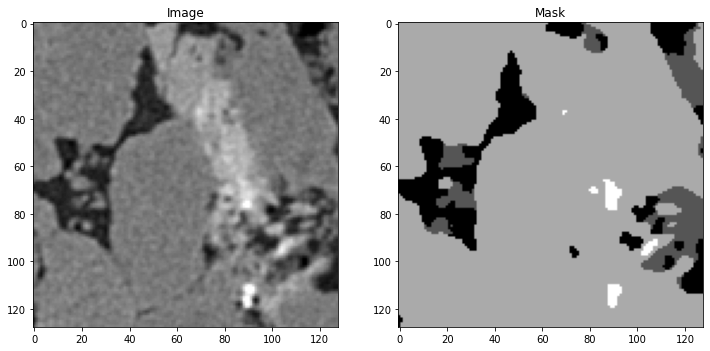

In [ ]:
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 0)
mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot, cmap='gray')
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
print("Unique values in the mask are: ", np.unique(mask_for_plot))
#Values are 1, 2, 3, 4. We need to encode them to 0, 1, 2, 3. This can be done by simply subtracting 1 but let us use label encoder as part of our datagen so it works in most situations. 

Unique values in the mask are:  [1 2 3 4]


In [ ]:
#Sample code to encode this single image. We will include this as part of our data gen. 
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
h, w = mask_for_plot.shape  
mask_for_plot_reshaped = mask_for_plot.reshape(-1,1)
mask_for_plot_reshaped_encoded = labelencoder.fit_transform(mask_for_plot_reshaped)
mask_for_plot_encoded = mask_for_plot_reshaped_encoded.reshape(h, w)
print("Unique values in the mask after endcoding are: ", np.unique(mask_for_plot_encoded))

Unique values in the mask after endcoding are:  [0 1 2 3]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Define Generator for images and masks so we can read them directly from the drive. 

In [ ]:

seed=24
batch_size= 16
n_classes=4

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    img = img / 255. #This can be done in ImageDataGenerator but showing it outside as an example
    #Convert mask to one-hot
    labelencoder = LabelEncoder()
    n, h, w, c = mask.shape  
    mask = mask.reshape(-1,1)
    mask = labelencoder.fit_transform(mask)
    mask = mask.reshape(n, h, w, c)
    mask = to_categorical(mask, num_class)
      
    return (img, mask)

#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        color_mode = 'grayscale',
        target_size=(128,128),
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        target_size=(128,128),
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)


In [ ]:
train_img_path = "/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches_for_dataaug_video121/train_images/"
train_mask_path = "/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches_for_dataaug_video121/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=4)

val_img_path = "/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches_for_dataaug_video121/val_images/"
val_mask_path = "/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches_for_dataaug_video121/val_masks"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=4)



In [ ]:
x, y = train_img_gen.__next__()


Found 1280 images belonging to 1 classes.
Found 1280 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(x.shape)
print(y.shape)
print("max value in image dataset is: ", x.max())

(16, 128, 128, 1)
(16, 128, 128, 4)
max value in image dataset is:  1.0


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


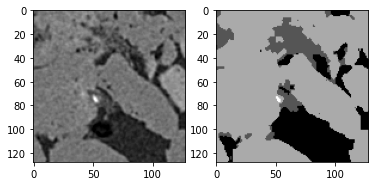

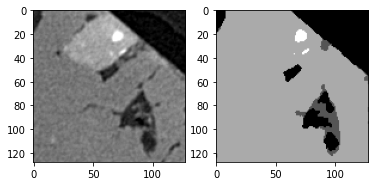

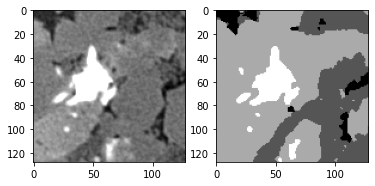

In [ ]:
#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i,:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()



Found 320 images belonging to 1 classes.
Found 320 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


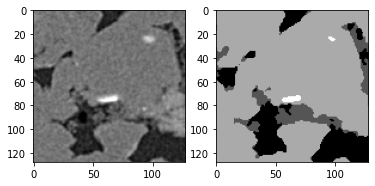

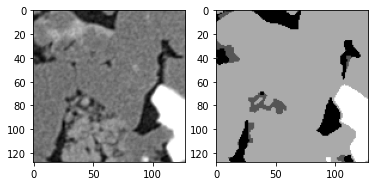

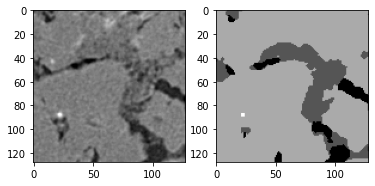

In [ ]:
x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i,:,:,0]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()


In [ ]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches_for_dataaug_video121/train_images/train'))
num_val_images = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches_for_dataaug_video121/val_images/val'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
n_classes=4

In [ ]:
model = build_unet(input_shape, n_classes=4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [ ]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


80/80 [==============================] - 46s 260ms/step - loss: 0.4780 - accuracy: 0.8589 - val_loss: 0.9822 - val_accuracy: 0.7658
Epoch 2/50
80/80 [==============================] - 19s 241ms/step - loss: 0.1278 - accuracy: 0.9594 - val_loss: 0.9857 - val_accuracy: 0.7688
Epoch 3/50
80/80 [==============================] - 19s 243ms/step - loss: 0.0997 - accuracy: 0.9642 - val_loss: 1.0887 - val_accuracy: 0.7899
Epoch 4/50
80/80 [==============================] - 19s 243ms/step - loss: 0.0949 - accuracy: 0.9645 - val_loss: 1.1820 - val_accuracy: 0.7891
Epoch 5/50
80/80 [==============================] - 19s 243ms/step - loss: 0.0883 - accuracy: 0.9665 - val_loss: 1.9916 - val_accuracy: 0.4083
Epoch 6/50
80/80 [==============================] - 19s 244ms/step - loss: 0.0846 - accuracy: 0.9673 - val_loss: 2.2653 - val_accuracy: 0.4044
Epoch 7/50
80/80 [==============================] - 20s 245ms/step - loss: 0.0831 - accuracy: 0.9674 - val_loss: 0.3799 - val_accuracy: 0.8679
Epoch 8/50

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial121_sandstone_50epochs.hdf5')

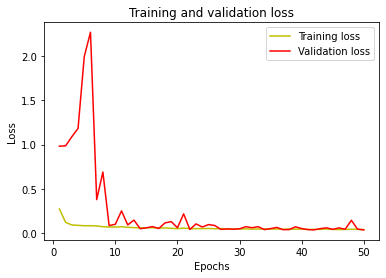

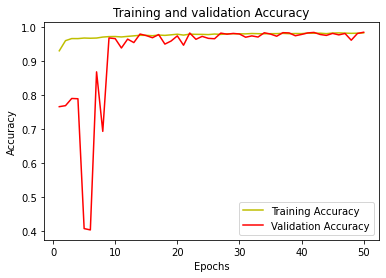

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial121_sandstone_50epochs.hdf5", compile=False)

In [ ]:
test_image_batch, test_mask_batch = val_img_gen.__next__()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_pred=model.predict(test_image_batch)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_argmax = np.argmax(test_mask_batch, axis=3)

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.92693686


In [ ]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)


[[3.01090e+04 2.89000e+02 3.18000e+02 0.00000e+00]
 [1.16600e+03 1.52430e+04 9.26000e+02 0.00000e+00]
 [3.94000e+02 1.01700e+03 2.07491e+05 8.10000e+01]
 [0.00000e+00 0.00000e+00 7.20000e+01 5.03800e+03]]
IoU for class1 is:  0.9328603
IoU for class2 is:  0.8177136
IoU for class3 is:  0.9866476
IoU for class4 is:  0.9705259


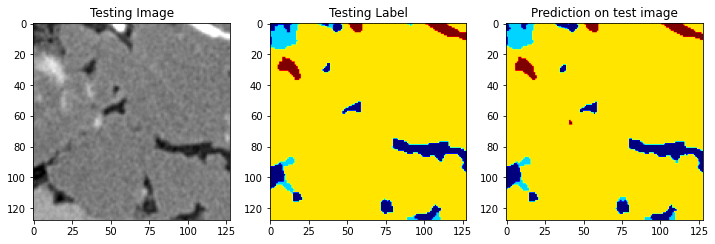

In [ ]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]
ground_truth = np.argmax(ground_truth, axis=2)
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()